<a href="https://colab.research.google.com/github/moreHS/StyleGAN_use/blob/main/StyleGAN_use.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b> 소스코드 및 사전 학습된(Pre-trained) 모델 다운로드</b>

* 저장소: https://github.com/ndb796/PyTorch-StyleGAN-Face-Editting

In [ ]:
# 저장소의 소스코드를 다운로드
!git clone https://github.com/ndb796/PyTorch-StyleGAN-Face-Editting

# Colab Notebook에서 해당 저장소 폴더로 이동
%cd PyTorch-StyleGAN-Face-Editting

# weights 폴더에 있는 사전 학습된(pre-trained) 모델의 압축 해제
!unzip weights/karras2019stylegan-ffhq-1024x1024.zip -d weights/

Cloning into 'PyTorch-StyleGAN-Face-Editting'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 112 (delta 24), reused 43 (delta 1), pack-reused 30
Receiving objects: 100% (112/112), 95.16 MiB | 31.09 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/PyTorch-StyleGAN-Face-Editting
Archive:  weights/karras2019stylegan-ffhq-1024x1024.zip
  inflating: weights/karras2019stylegan-ffhq-1024x1024.pt  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models 
from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

#### <b> 사전 학습된 모델 불러오기</b>

* FFHQ는 1024 x 1024 고해상도 이미지 데이터셋입니다.
* FFHQ 데이터셋으로 학습된 StyleGAN을 구성하는 두 개의 네트워크를 불러옵니다.
    * Latent vector를 매핑(mapping)해주는 <b>g_mapping</b> 네트워크
    * Latent vector를 이미지로 바꾸어주는 <b>g_synthesis</b> 네트워크

* 사전 학습된 모델은 다음과 같은 형태로 불러올 수 있습니다.

```
# StyleGAN을 구성하는 두 개의 네트워크 불러오기
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)

g_mapping, g_synthesis = g_all[0], g_all[1]
```

In [ ]:
# 필요한 라이브러리 불러오기
from stylegan_model import G_mapping
from stylegan_model import G_synthesis

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
resolution = 1024
weight_file = 'weights/karras2019stylegan-ffhq-1024x1024.pt'

# StyleGAN을 구성하는 두 개의 네트워크 불러오기
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)
 
g_mapping, g_synthesis = g_all[0], g_all[1]

#### <b> 이미지 처리 함수 구현하기</b>

* 이미지를 처리하는 두 개의 함수를 구현합니다.
    * image_reader(): 특정한 경로에서 이미지를 읽어 PyTorch의 Tensor 객체로 변환하는 함수
    * imshow(): Tensor 객체를 화면에 출력하는 함수

In [ ]:
# 특정 경로에서 이미지를 읽어 torch.Tensor 객체로 만드는 함수
def image_reader(image_path, resize=None):
    with open(image_path, "rb") as f: # 특정 경로에서 이미지 불러오기
        image = Image.open(f)
        image = image.convert("RGB") # RGB 색상 이미지로 사용
    # 미리 정해 놓은 해상도에 맞게 크기 변환
    if resize != None:
        image = image.resize((resize, resize))
    transform = transforms.Compose([
        transforms.ToTensor() # [0, 1] 사이의 값을 가지는 Tensor 형태로 변형
    ])
    image = transform(image)
    image = image.unsqueeze(0) # 배치(batch) 목적의 차원 추가 (N, C, H, W)
    return image


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension)을 제거
    image = image.squeeze(0)
    gray_scale = False # 흑백 이미지 여부
    if image.shape[0] == 1:
        gray_scale = True
    # PIL 객체로 변경
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 출력)
    if gray_scale: # 흑백인 경우 흑백 색상으로 출력
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# 화면에 출력되는 이미지 크기 조절
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

#### <b> 랜덤한 이미지 생성하기</b>

* StyleGAN은 가우시안 분포 대신에 W 공간의 latent vector w를 사용합니다.
* g_mapping 네트워크를 이용해 z 벡터를 w 벡터로 변경합니다.
    * <b>z 벡터</b>: 가우시안 분포를 따르는 512 차원의 벡터
    * <b>w 벡터</b>: 학습된 분포를 따르는 18 X 512 차원의 벡터
* 단순히 네트워크에 넣어 이미지 결과를 확인할 때는 기울기 추적을 사용하지 않습니다.
    * 향후 latent vector를 업데이트할 때는 기울기를 추적합니다.

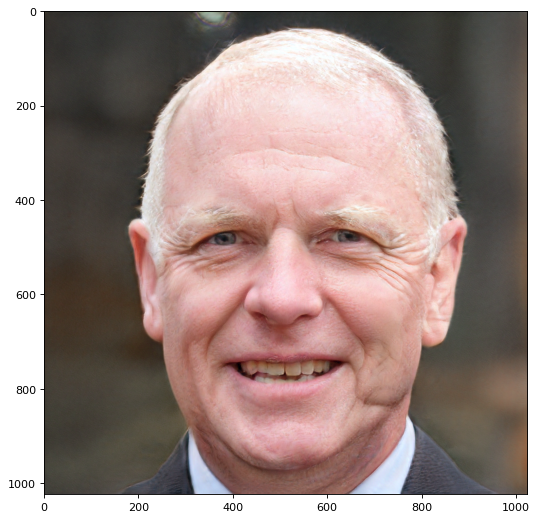

In [ ]:
# 랜덤한 latent vector z를 샘플링하기
z = torch.randn((1, 512), requires_grad=False, device=device)

# Z에서 W 공간으로 매핑(mapping)
w = g_mapping(z)

# 만들어진 이미지는 [-1, 1]의 범위를 가지므로 이를 조정하여 시각화
image = g_synthesis(w)
image = ((image + 1.0) / 2.0).clamp(0, 1)

imshow(image)

# <b>* 얼굴 임베딩(Face Embedding)</b>

#### <b>핵심 아이디어</b>

* 얼굴 임베딩을 위해 <b>경사 하강(gradient descent)</b>을 수행해 w+ 벡터를 업데이트합니다.
* 단순히 이미지 공간에서의 MSE 손실(loss)만을 이용할 때보다 VGG를 활용한 Perceptual Loss를 함께 이용할 때 잘 동작합니다.

#### <b> 특징 추출기(Feature Extractor) 구현</b>

* VGG Feature Extractor
    * VGG 네트워크의 활성화 맵(activation map)을 반환하는 함수입니다.
    * Perceptual Loss를 계산할 때 사용됩니다.

In [ ]:
import warnings
warnings.filterwarnings(action='ignore') # 경고(warning) 메시지 보이지 않도록 하기


# VGG를 활용한 특징 추출기(Feature Extractor)
class FeatureExtractor(torch.nn.Module):
    def __init__(self, n_layers):
        super(FeatureExtractor, self).__init__()
        extractor = models.vgg16(pretrained=True).features

        # 각 레이어까지의 출력 값을 계산 (n_layers=[1, 3, 13, 20])
        index = 0
        self.layers = nn.ModuleList([])
        for i in range(len(n_layers)):
            # 해당 레이어까지의 출력 값을 내보낼 수 있도록 하기
            self.layers.append(torch.nn.Sequential())
            for j in range(index, n_layers[i] + 1):
                self.layers[i].add_module(str(j), extractor[j])
            index = n_layers[i] + 1

        # 모델을 학습할 필요는 없으므로 기울기 추적 중지
        for param in self.parameters():
            param.requires_grad = False

    # 각 레이어까지의 출력 값들을 리스트에 담아 반환
    def forward(self, x):
        result = []
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            result.append(x)

        return result

#### <b> Perceptual Loss를 활용한 손실(Loss) 함수 구현하기</b>

* VGG 네트워크의 활성화 맵(activation map) 상의 MSE 손실을 구합니다.
* G(w)와 원본 이미지 사이에서 픽셀 상의 MSE 손실을 구합니다.

In [ ]:
# 생성된 이미지(generated_image)와 대상 이미지(target_image)에 대한 손실(loss)을 계산
def loss_function(generated_image, target_image, feature_extractor):
    MSE = nn.MSELoss(reduction='mean')
    mse_loss = MSE(generated_image, target_image) # 손실(loss) 값 계산

    # VGG 네트워크의 입력은 256이므로, 크기를 256으로 바꾸는 업샘플링(upsampling)을 이용합니다.
    upsample2d = torch.nn.Upsample(scale_factor=256 / resolution, mode='bilinear')
    real_features = feature_extractor(upsample2d(target_image))
    generated_features = feature_extractor(upsample2d(generated_image))

    perceptual_loss = 0
    # 활성화 맵(activation map)의 개수만큼 반복하며
    for i in range(len(real_features)):
        perceptual_loss += MSE(real_features[i], generated_features[i]) # 손실(loss) 값 계산

    return mse_loss, perceptual_loss

#### <b> 이미지 임베딩 실습</b>

[iter 1/3000] loss = 2.195023536682129, saved_path = face1_1.png
[iter 100/3000] loss = 0.9312319159507751, saved_path = face1_100.png
[iter 200/3000] loss = 0.8588350415229797, saved_path = face1_200.png
[iter 300/3000] loss = 0.7284232378005981, saved_path = face1_300.png
[iter 400/3000] loss = 0.6912044286727905, saved_path = face1_400.png
[iter 500/3000] loss = 0.6443050503730774, saved_path = face1_500.png
[iter 600/3000] loss = 0.6188235282897949, saved_path = face1_600.png
[iter 700/3000] loss = 0.5945331454277039, saved_path = face1_700.png
[iter 800/3000] loss = 0.5725411176681519, saved_path = face1_800.png
[iter 900/3000] loss = 0.5571814775466919, saved_path = face1_900.png
[iter 1000/3000] loss = 0.5494565963745117, saved_path = face1_1000.png
[iter 1100/3000] loss = 0.5472339391708374, saved_path = face1_1100.png
[iter 1200/3000] loss = 0.5331293344497681, saved_path = face1_1200.png
[iter 1300/3000] loss = 0.5113185048103333, saved_path = face1_1300.png
[iter 1400/3000] 

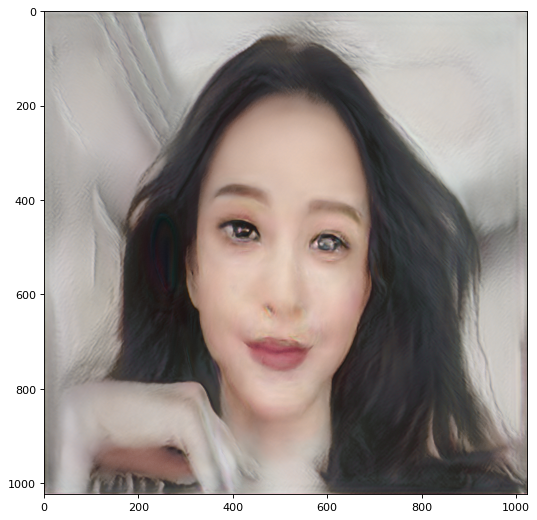

In [ ]:
# Google Drive 연결
from google.colab import drive
drive.mount('/content/drive')


latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr=0.03, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers=[3, 7, 13, 20]).to(device)

# 이미지 불러오기
src = '/content/drive/MyDrive/face1.png'
name = 'face1'
image = image_reader(src, resize=resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 3000
for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += 0.8*mse_loss + 0.2*perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        if (i + 1) % 500 == 0:
          save_image(generated_image, f'{name}_{i + 1}.png')

        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

#### <b> 두 이미지간 모핑(Morphing) 구현하기</b>

In [ ]:
print('[ 이미지 보간법(Interpolation) ]')

# .npy 파일로부터 두 w 벡터 불러오기
w_1 = np.load('barack_obama_latent.npy')
w_2 = np.load('hugh_jackman_latent.npy')

name = 'interpolation'
interpolated_images = []

# 두 벡터간 모핑(morphing) 수행하기
with torch.no_grad(): # GPU 용량 낭비를 줄이기 위해 기울기를 추적하지 않도록 하기
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w)
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# 결과 이미지를 격자(grid) 형태로 저장
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

# <b>* 임베딩 벡터 연산(Latent Vector Arithmetic)</b>

#### <b>핵심 아이디어 설명</b>

* 일반적인 GAN과 마찬가지로 StyleGAN에서도 Latent Vector 간의 연산을 수행할 수 있습니다.
* 웃는 얼굴(Smile Face)에서 무표정 얼굴(Neutral Face)을 빼서 웃는 얼굴에 대한 시맨틱(semantic) 정보를 얻을 수 있습니다.

#### <b>웃는 얼굴(Smile Face) 임베딩하기</b>

In [ ]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

# 이미지 불러오기
src = 'images/face_smile.bmp'
name = 'face_smile'
image = image_reader(src, resize=resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

#### <b>무표정 얼굴(Neutral Face) 임베딩하기</b>

In [ ]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

# 이미지 불러오기
src = 'images/face_neutral.bmp'
name = 'face_neutral'
image = image_reader(src, resize=resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

#### <b> 임베딩 간 벡터 연산하기</b>

In [ ]:
# 웃는 얼굴 임베딩 불러오기
smile_latent = np.load('face_smile_latent.npy')

# 무표정 얼굴 임베딩 불러오기
neutral_latent = np.load('face_neutral_latent.npy')

# 벡터 연산 수행하기
smile_direction = smile_latent - neutral_latent

#### <b>벡터 연산으로 얼굴 편집하기</b>

In [ ]:
interpolated_images = []

# 이미지 임베딩 불러오기
name = 'smile'
target_latent = np.load('barack_obama_latent.npy')

# 벡터 연산으로 얼굴 편집하기
with torch.no_grad(): # GPU 용량 낭비를 줄이기 위해 기울기를 추적하지 않도록 하기
    for alpha in np.linspace(0, 0.2, 10):
        w = target_latent + alpha * smile_direction # 웃는 방향으로 벡터 이동
        w = torch.tensor(w).to(device)
        image = g_synthesis(w)
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# 결과 이미지를 격자(grid) 형태로 저장
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

# <b>* 시맨틱 정보 변경(Semantic Editing)</b>

In [ ]:
# 바운더리(boundary) 불러오기
boundary_name = 'stylegan_ffhq_gender_w_boundary.npy' # 성별
# boundary_name = 'stylegan_ffhq_age_w_boundary.npy' # 나이
# boundary_name = 'stylegan_ffhq_pose_w_boundary.npy' # 좌우포즈
# boundary_name = 'stylegan_ffhq_smile_w_boundary.npy' # 웃음
# boundary_name = 'stylegan_ffhq_eyeglasses_w_boundary.npy' # 안경

boundary = np.load(f'boundaries/{boundary_name}')

# 이미지 임베딩 불러오기
name = 'gender'
latent = np.load('hugh_jackman_latent.npy')

boundary_images = []

# 방향 벡터를 활용해 시맨틱 정보 변경하기
with torch.no_grad(): # GPU 용량 낭비를 줄이기 위해 기울기를 추적하지 않도록 하기
    boundary = boundary.reshape(1, 1, -1)
    linspace = np.linspace(-3.0, 3.0, 10)
    linspace = linspace.reshape(-1, 1, 1)

    w = latent + linspace * boundary
    w = torch.tensor(w).to(torch.float).to(device)

    image = g_synthesis(w)
    image = (image + 1.0) / 2.0
    image = image.clamp(0, 1)
    boundary_images.append(image)

# 결과 이미지를 격자(grid) 형태로 저장
grid_image = torchvision.utils.make_grid(torch.cat(boundary_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

# <b>* 스타일 전송(Style Transfer)</b>

#### <b>핵심 아이디어 설명</b>

* 일반적으로 사용되는 Style Transfer의 아이디어를 적용할 수 있습니다.
* Latent Vector w+의 앞쪽은 콘텐츠(Content), 뒤쪽은 스타일(Style)로 간주합니다.

#### <b>스타일 이미지 임베딩하기</b>

In [ ]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr=0.05, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers=[0, 2, 7, 12]).to(device)

# 이미지 불러오기
src = 'images/tiger_cartoon.jpg'
name = 'tiger_cartoon'
image = image_reader(src, resize=resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

#### <b>그림체 스타일 전송하기</b>

In [ ]:
# 콘텐츠 이미지 임베딩 불러오기
content_latent = np.load('barack_obama_latent.npy')

# 스타일 이미지 임베딩 불러오기
style_latent = np.load('tiger_cartoon_latent.npy')

style_transfer_images = []

# 스타일 전송(Style Transfer) 수행
with torch.no_grad(): # GPU 용량 낭비를 줄이기 위해 기울기를 추적하지 않도록 하기
    for crossover_point in range(6, 14):
        # 두 개의 w 벡터를 교차점(crossover point)를 기준으로 섞어하기
        w = np.concatenate((content_latent[:,:crossover_point,:], style_latent[:,crossover_point:,:]), axis=1)
        w = torch.tensor(w).to(device)
        image = g_synthesis(w)
        image = (image + 1.0) / 2.0
        image = image.clamp(0, 1)
        style_transfer_images.append(image)

# 결과 이미지를 격자(grid) 형태로 저장
grid_image = torchvision.utils.make_grid(torch.cat(style_transfer_images, dim=0), nrow=4)
save_image(grid_image, f"{name}.png")
imshow(grid_image)